# Predicting Student Admissions with Neural Networks



In [2]:
# importing pandas and numpy
import pandas as pd
import numpy as np

# read csv file into a pd dataframe
data = pd.read_csv('student_data.csv')

# show the first 10 rows of the data
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Plotting the data

In [7]:
X = np.array(data[["gre", "gpa"]])
y = np.array(data["admit"])
    
admitted = X[np.argwhere(y==1)]
rejected = X[np.argwhere(y==0)]
rejected.shape


(273, 1, 2)

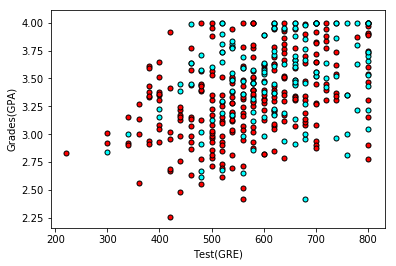

In [12]:
import matplotlib.pyplot as plt

def plot_points(data):
    X = np.array(data[["gre", "gpa"]])
    y = np.array(data["admit"])
    
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s=25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test(GRE)')
    plt.ylabel('Grades(GPA)')
    
# plot the points
plot_points(data)
plt.show()
   

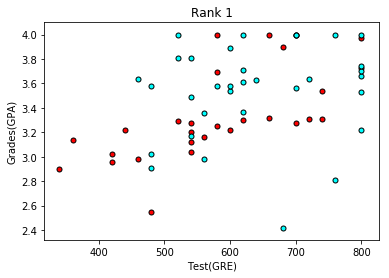

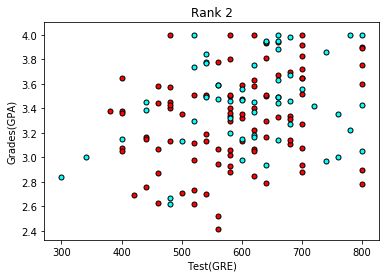

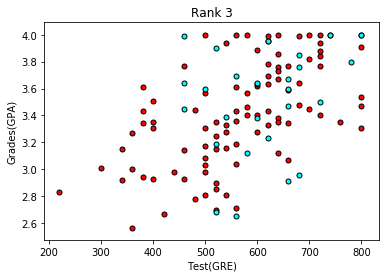

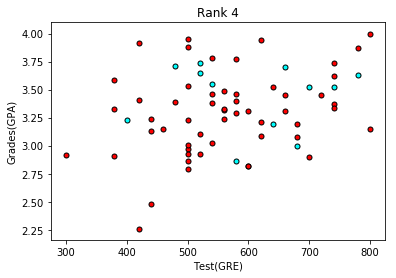

In [13]:
#separate ranks
data_rank1 = data[data['rank']==1]
data_rank2 = data[data['rank']==2]
data_rank3 = data[data['rank']==3]
data_rank4 = data[data['rank']==4]

#plot each graph
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()


plot_points(data_rank2)
plt.title("Rank 2")
plt.show()


plot_points(data_rank3)
plt.title("Rank 3")
plt.show()


plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

## One-hot encoding the rank

In [41]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data["rank"], prefix='rank')], axis = 1) 
# Drop the previous rank column
one_hot_data = one_hot_data.drop(["rank"], axis = 1 )
one_hot_data[:5]


### or i could have used this:
### one_hot_data = pd.get_dummies(data, columns=['rank'])


,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


## Scaling the data

In [42]:
# Make a copy of the data
processed_data = one_hot_data[:]

# Scale the columns
processed_data['gpa'] /= 4.0
processed_data['gre'] /= 800

processed_data[:5]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1


## Splitting the data into Training and Testing

In [44]:
sample = np.random.choice( processed_data.index, size =int(len(processed_data)*0.9), replace = False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:5])
print(test_data[:5])

Number of training samples is 360
Number of testing samples is 40
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
243      0  0.775  0.8050       0       1       0       0
387      0  0.725  0.8400       0       1       0       0
308      0  0.675  0.7825       0       1       0       0
377      1  1.000  1.0000       0       1       0       0
222      1  0.600  0.7550       1       0       0       0
    admit    gre    gpa  rank_1  rank_2  rank_3  rank_4
6       1  0.700  0.745       1       0       0       0
12      1  0.950  1.000       1       0       0       0
30      0  0.675  0.945       0       0       0       1
59      0  0.750  0.705       0       0       0       1
60      1  0.775  0.795       0       1       0       0


## Splitting the data into features and targets (labels)

In [46]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

print(features[:5])
print(targets[:5])

       gre     gpa  rank_1  rank_2  rank_3  rank_4
243  0.775  0.8050       0       1       0       0
387  0.725  0.8400       0       1       0       0
308  0.675  0.7825       0       1       0       0
377  1.000  1.0000       0       1       0       0
222  0.600  0.7550       1       0       0       0
243    0
387    0
308    0
377    1
222    1
Name: admit, dtype: int64


## Training the 2-layer Neural Network

In [47]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1/ (1+ np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def error_formula(y, output):
    return -y* np.log(output) - (1-y) * np.log(1-output)

## Backpropagate the error

In [48]:
# Write the error term formula
def error_term_formula(x, y, output):
    return (y - output) * sigmoid_prime(x)

In [56]:
# Neural Network hyperparameters

epochs = 1000
learnrate = 0.5

# Training function
def train_nn( features, targets, epochs, learnrate):
    np.random.seed(42)
    n_records, n_features = features.shape
    last_loss = None
    
    # Initialize the weights
    weights = np.random.normal(scale=1 / n_features**.5, size = n_features)
    
    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            
            # Activation of the output unit
            output = sigmoid(np.dot(x, weights))
            
            # The error
            error = error_formula(y, output)
            
            # The error term
            error_term = error_term_formula(x,y,output)
            
            # The gradient descent step
            del_w += error_term * x
            
        # Update weights
        weights += learnrate * del_w / n_records
        
        # Print out the MSE on the training set
        if e % (epochs/10) == 0:
            out  = sigmoid(np.dot(features,weights))
            loss = np.mean((out - targets)**2)
            
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights

    
# Call the training function
weights = train_nn(features, targets, epochs, learnrate)

Epoch: 0
Train loss:  0.27354951897659385
Epoch: 100
Train loss:  0.21360388874363798
Epoch: 200
Train loss:  0.21181371328395662
Epoch: 300
Train loss:  0.21089198094857023
Epoch: 400
Train loss:  0.21038447796549065
Epoch: 500
Train loss:  0.2100735763238312
Epoch: 600
Train loss:  0.2098577453322471
Epoch: 700
Train loss:  0.20968934244918197
Epoch: 800
Train loss:  0.20954561572027217
Epoch: 900
Train loss:  0.20941547847995892
Finished training!


## Calculate the accuracy on the test data

In [58]:
test_out    = sigmoid(np.dot(features_test, weights))
predictions = test_out > 0.5
accuracy    = np.mean( predictions == targets_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.800
